In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('anomaly_detection.csv')
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


# Data Splitting

In [4]:
# df = df[df.agency == "AAA"]
# df = df.reset_index(drop=True)

In [5]:
df["date"] = pd.to_datetime(df["date"])
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["Day"] = df["date"].dt.day
df["DayName"] = df["date"].dt.day_name()

In [6]:
df.Year.value_counts()

Year
2020    1098
2024    1098
2021    1095
2022    1095
2023    1095
2025      93
Name: count, dtype: int64

In [7]:
train = df[df.date <= "2023-06-30"].copy()
train.reset_index(drop=True, inplace=True)

valid = df[(df.date > "2023-06-30") & (df.date <= "2023-12-31")].copy()
valid.reset_index(drop=True, inplace=True)

test = df[df.date > "2023-12-31"].copy()
test.reset_index(drop=True, inplace=True)

In [8]:
train.shape, valid.shape, test.shape

((3831, 8), (552, 8), (1191, 8))

Since this is a  timeseries dataset, we decided to use data from 2020-mid 2023 as train set, remainder of 2023 as validation dataset, and the entirety of 2024 and 2025 as test set. We can also change the date ranges for each of these sets.

# EDA

In [11]:
train

,date,value,agency,anomaly,Year,Month,Day,DayName
0,2020-01-01,197,AAA,0,2020,1,1,Wednesday
1,2020-01-01,404,CCC,0,2020,1,1,Wednesday
2,2020-01-01,153,BBB,0,2020,1,1,Wednesday
3,2020-01-02,205,AAA,0,2020,1,2,Thursday
4,2020-01-02,401,CCC,0,2020,1,2,Thursday
...,...,...,...,...,...,...,...,...
3826,2023-06-29,271,CCC,0,2023,6,29,Thursday
3827,2023-06-29,275,AAA,0,2023,6,29,Thursday
3828,2023-06-30,288,AAA,1,2023,6,30,Friday
3829,2023-06-30,291,CCC,1,2023,6,30,Friday


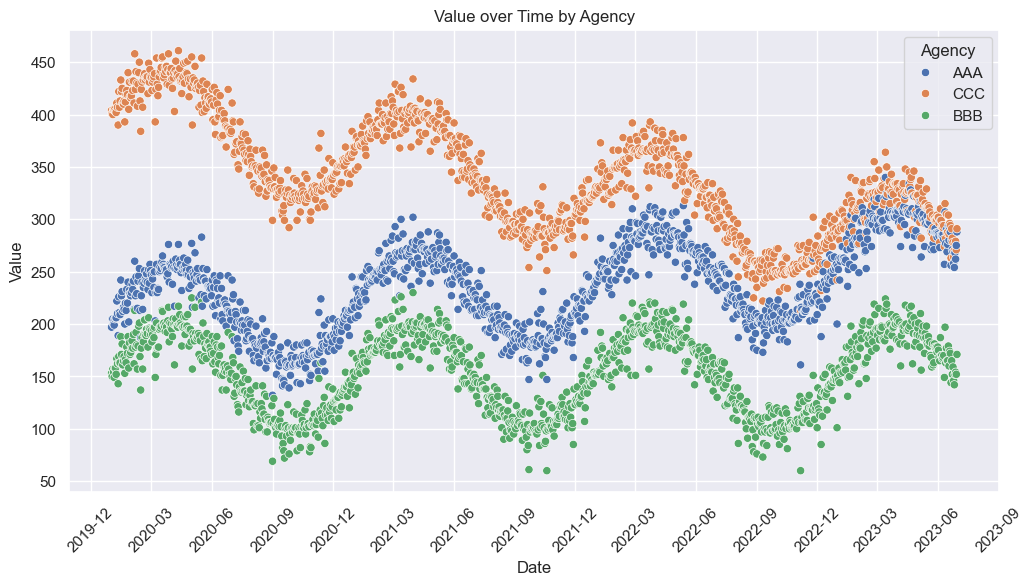

In [12]:
import matplotlib.dates as mdates

sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='date', y='value', hue='agency')
plt.title('Value over Time by Agency')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Agency')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-06-30'))
plt.xticks(rotation=45)
plt.show()

If we look here, we can see that the values for each agencies are very much seperable. In fact, besides few data points overlapping between agencies, their pattern is very much seperable as they have a similar pattern with respect to time. The values for each agency seems to be peaking around march/april and lowest are recorded around Sep/Oct every year.

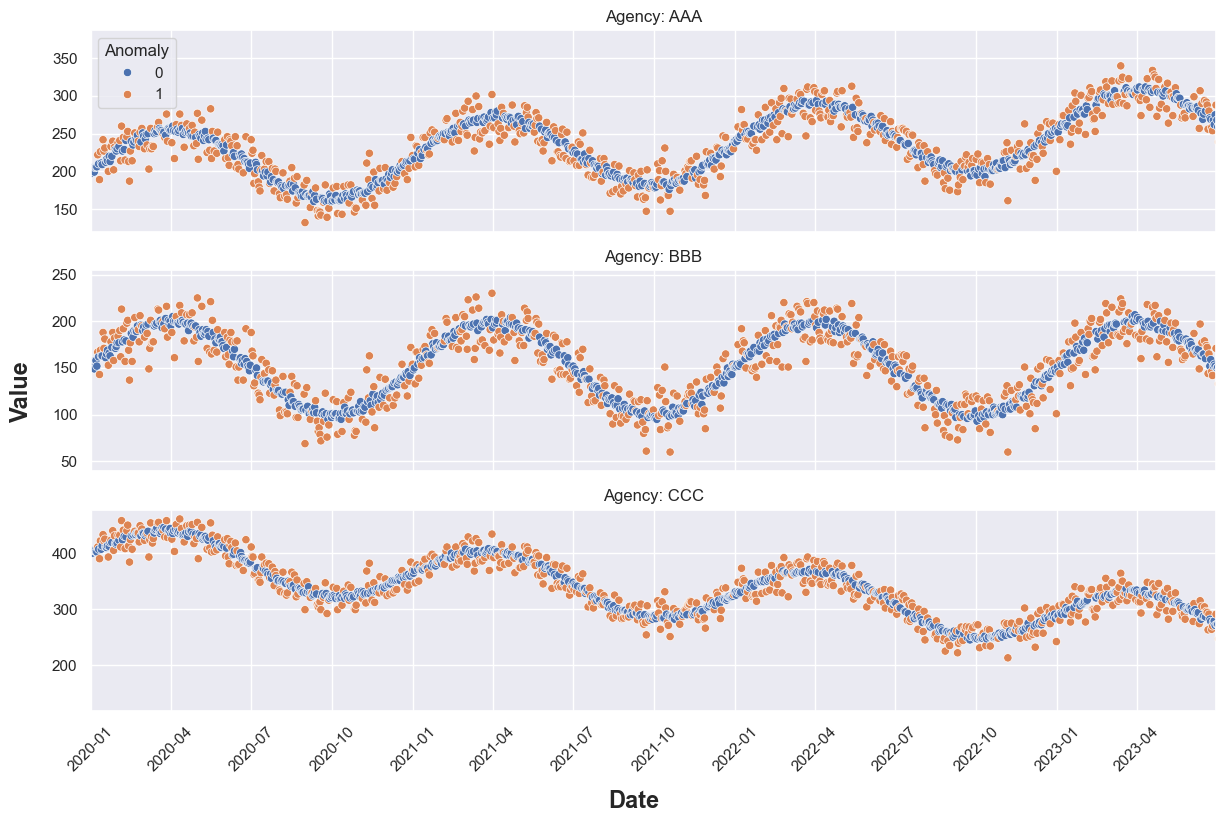

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

agencies = ['AAA', 'BBB', 'CCC']
for i, agency in enumerate(agencies):
    sns.scatterplot(ax=axes[i], data=df[df['agency'] == agency], x='date', y='value', hue='anomaly')
    axes[i].set_title(f'Agency: {agency}')
    axes[i].legend(title='Anomaly')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # we only need one legend
    if i != 0:
        axes[i].get_legend().remove()

    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-06-30'))
    axes[i].tick_params(axis='x', rotation=45)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=17, fontweight='bold')
fig.text(-0.02, 0.5, 'Value', va='center', rotation='vertical', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

If we look at each of these agencies. the middle values in general seem to be the anomalies and the data points surrounding the anomalies are the non-anomalies. This is a complex non-linear relationship and it is very unlikely a simple logistic regression based classification would yield higher accuracy. Besides, there is the factor of date. The values follow a trend, and we will need to transform date in a way that our model will be able to understand the relationship.

For instance, the value is decreasing for both anomalies and non-anomalies for agency CCC. This pattern needs to be preserved while making predictions on test set which consists of data from 2024/25. Similarly, for agency AAA, the values seem to be gradually increasing whereas, for BBB, it looks constant.

In [16]:
print("Number of anomalies in train data with respect to agency: \n")
print(train.groupby('agency')["anomaly"].value_counts())

Number of anomalies in train data with respect to agency: 

agency  anomaly
AAA     0          687
        1          590
BBB     0          687
        1          590
CCC     0          687
        1          590
Name: count, dtype: int64


It looks like the distribution of samples between anomalies and non-anomalies is pretty balanced. This is good as we won't have to worry about challenges associated with class-imbalance. Generally, you would expect the anomalies to be rare. Here, both are equal.

In [18]:
train

,date,value,agency,anomaly,Year,Month,Day,DayName
0,2020-01-01,197,AAA,0,2020,1,1,Wednesday
1,2020-01-01,404,CCC,0,2020,1,1,Wednesday
2,2020-01-01,153,BBB,0,2020,1,1,Wednesday
3,2020-01-02,205,AAA,0,2020,1,2,Thursday
4,2020-01-02,401,CCC,0,2020,1,2,Thursday
...,...,...,...,...,...,...,...,...
3826,2023-06-29,271,CCC,0,2023,6,29,Thursday
3827,2023-06-29,275,AAA,0,2023,6,29,Thursday
3828,2023-06-30,288,AAA,1,2023,6,30,Friday
3829,2023-06-30,291,CCC,1,2023,6,30,Friday


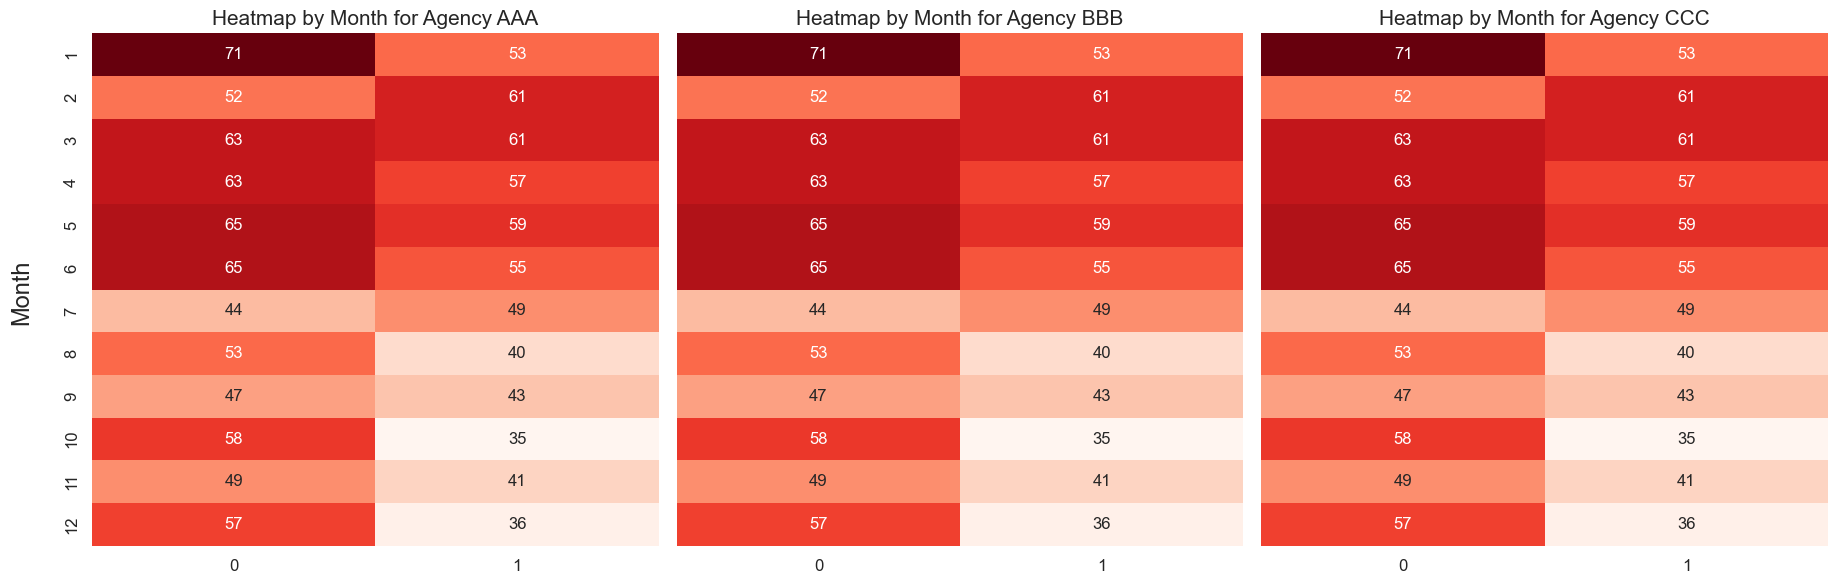

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

agencies = ['AAA', 'BBB', 'CCC']
for i, agency in enumerate(agencies):
    pivot_table = train[train.agency == agency].pivot_table(index='Month', columns='anomaly', values='value', aggfunc='count', fill_value=0)
    
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Reds', ax=axes[i], cbar=False)
    axes[i].set_title(f'Heatmap by Month for Agency {agency}', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

fig.text(-0.02, 0.5, 'Month', va='center', rotation='vertical', fontsize=17, fontweight='normal')

plt.tight_layout()
plt.show()

Well, looks like the number of anomalies and non-anomalies for each agency for each month is essentially the same. Let's look at the average values.

In [21]:
train

,date,value,agency,anomaly,Year,Month,Day,DayName
0,2020-01-01,197,AAA,0,2020,1,1,Wednesday
1,2020-01-01,404,CCC,0,2020,1,1,Wednesday
2,2020-01-01,153,BBB,0,2020,1,1,Wednesday
3,2020-01-02,205,AAA,0,2020,1,2,Thursday
4,2020-01-02,401,CCC,0,2020,1,2,Thursday
...,...,...,...,...,...,...,...,...
3826,2023-06-29,271,CCC,0,2023,6,29,Thursday
3827,2023-06-29,275,AAA,0,2023,6,29,Thursday
3828,2023-06-30,288,AAA,1,2023,6,30,Friday
3829,2023-06-30,291,CCC,1,2023,6,30,Friday


In [22]:
print(train.groupby("DayName")["anomaly"].value_counts())

DayName    anomaly
Friday     0          300
           1          249
Monday     0          294
           1          252
Saturday   0          306
           1          240
Sunday     0          276
           1          270
Thursday   0          303
           1          246
Tuesday    0          300
           1          246
Wednesday  0          282
           1          267
Name: count, dtype: int64


This is also not much helpful. It looks like the data is pretty much balanced with respect to the number of samples in each category from every aspect.

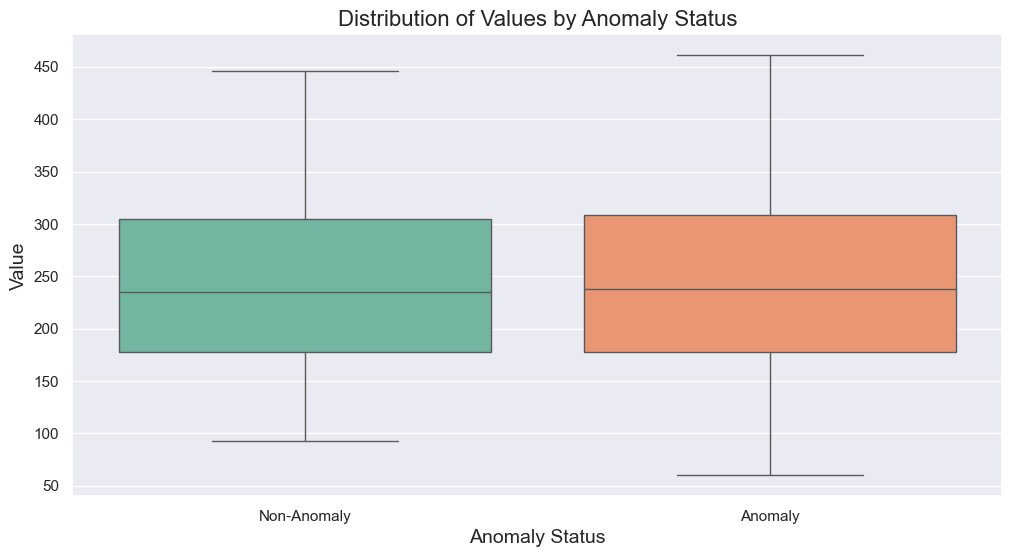

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x="anomaly", y="value", palette="Set2")
plt.title('Distribution of Values by Anomaly Status', fontsize=16)
plt.xlabel('Anomaly Status', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks([0, 1], ['Non-Anomaly', 'Anomaly'])
plt.show()

In general, of course, there is not much difference between the distribution of non-anomaly and anomaly values.

In [26]:
train_base = train.copy()
valid_base = valid.copy()
test_base = test.copy()

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

We will here define the optimizer that we are going to use. It will be a randomized search over a Random forest classifier, as that is what has yielded the best results.

In [29]:
def optimize_model(X_train, X_valid, y_train, y_valid, param_space, n_iter):
    X_train_valid = np.concatenate([X_train, X_valid])
    y_train_valid = np.concatenate([y_train, y_valid])
    
    split_index = [-1] * len(X_train) + [0] * len(X_valid)
    predefined_split = 5 #PredefinedSplit(test_fold=split_index)
    model = RandomForestClassifier(random_state=42)
    
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_space, 
                                       n_iter=n_iter, scoring='accuracy', verbose=1, 
                                       random_state=42, n_jobs=-1, cv=predefined_split)
    
    random_search.fit(X_train_valid, y_train_valid)
    #return the best features for esimating
    best_model = random_search.best_estimator_    
    return best_model

# Data Engineering with Timeseries data + RF-Modelling

In [31]:
train = train_base.copy()
valid = valid_base.copy()
test = test_base.copy()

In [32]:
len(pd.date_range(start='2020-01-01', end='2023-06-30', freq='D')) == len(train), len(pd.date_range(start='2023-07-01', end='2023-12-31', freq='D')) == len(valid), \
                        len(pd.date_range(start='2024-01-01', end='2025-01-31', freq='D')) == len(test)

(False, False, False)

In [33]:
train_AAA = train[train.agency == "AAA"].copy()
valid_AAA = valid[valid.agency == "AAA"].copy()
test_AAA = test[test.agency == "AAA"].copy()

train_BBB = train[train.agency == "BBB"].copy()
valid_BBB = valid[valid.agency == "BBB"].copy()
test_BBB = test[test.agency == "BBB"].copy()

train_CCC = train[train.agency == "CCC"].copy()
valid_CCC = valid[valid.agency == "CCC"].copy()
test_CCC = test[test.agency == "CCC"].copy()

train_AAA = train_AAA[["date", "value", "anomaly", "agency"]]
valid_AAA = valid_AAA[["date", "value", "anomaly", "agency"]]
test_AAA = test_AAA[["date", "value", "anomaly", "agency"]]

train_BBB = train_BBB[["date", "value", "anomaly", "agency"]]
valid_BBB = valid_BBB[["date", "value", "anomaly", "agency"]]
test_BBB = test_BBB[["date", "value", "anomaly", "agency"]]

train_CCC = train_CCC[["date", "value", "anomaly", "agency"]]
valid_CCC = valid_CCC[["date", "value", "anomaly", "agency"]]
test_CCC = test_CCC[["date", "value", "anomaly", "agency"]]

In [34]:
dayname_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

In [35]:
import numpy as np
import pandas as pd

target = "anomaly"
#from tqdm import tqdm

from sklearn.linear_model import LinearRegression

def calc_rolling_slope(values, window):
    slopes = [np.nan]*window
    for i in range(window, len(values)):
        y = values[i-window:i]
        x = np.arange(window).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        slopes.append(model.coef_[0])
    return slopes

def apply_transformations(df):
    df = df.copy()
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['DayName'] = df['date'].dt.day_name()

    # Cyclical encoding for temporal features
    # Calculating trigonometric functions over the course of the year based on both month and day (of month and week)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    dayname_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
    df['DayName_num'] = df['DayName'].map(dayname_to_num)
    df['DayName_sin'] = np.sin(2 * np.pi * df['DayName_num'] / 7)
    df['DayName_cos'] = np.cos(2 * np.pi * df['DayName_num'] / 7)

    # Lagged features
    # Calculate the difference between different days (# of day is the lag number)
    #lag_1 - The value 1 day ago
    #Diff_1 - The difference in values between today and 1 day ago
    #ROC_1 - The slope of the line between the values of today and 1 day ago
 
    lags = [1, 2, 3, 7, 14]
    for lag in lags:
        df[f'lag_{lag}'] = df['value'].shift(lag)

        # Difference features for all lags
        df[f'diff_{lag}'] = df['value'] - df[f'lag_{lag}']
        
        # Rate of change for all lags
        df[f'roc_{lag}'] = (df['value'] - df[f'lag_{lag}']) / (df[f'lag_{lag}'] + 1e-6)


    # Rolling statistics (we can increase these)
    #Rolling_min_7 - 
    #Rolling_max_7 - 
    #Rolling_mean_7 - 
    #Rolling_std_7 - 
    #Rolling_range_7 - 
    #Rolling_momentum_7 - 
    #Rolling_momentum_7 - 
    
    windows = [7, 14]
    for window in windows:
        df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()
        df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
        df[f'rolling_range_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']
        df[f'rolling_momentum_{window}'] = df['value'] - df['value'].shift(window)

        # z-score for all windows
        df[f'zscore_{window}'] = (df['value'] - df[f'rolling_mean_{window}']) / (df[f'rolling_std_{window}'] + 1e-6)

        # Exponential moving averages for all spans
        df[f'ema_{window}'] = df['value'].ewm(span=window, adjust=False).mean()

        # calculate short term and long terms slopes as they can help us caputure local trends (first and second order derivatives)
        df[f'slope_{window}'] = calc_rolling_slope(df['value'].values, window)
        df[f'acceleration_{window}'] = df[f'slope_{window}'] - df[f'slope_{window}'].shift(1)

        df[f'relative_to_mean_{window}'] = df['value'] / (df[f'rolling_mean_{window}'] + 1e-6)
        df[f'relative_to_max_{window}'] = df['value'] / (df[f'rolling_max_{window}'] + 1e-6)
        df[f'relative_to_min_{window}'] = df['value'] / (df[f'rolling_min_{window}'] + 1e-6)

        df[f'rolling_skew_{window}'] = df['value'].rolling(7).skew()
        df[f'rolling_kurtosis_{window}'] = df['value'].rolling(7).kurt()
        df[f"residual_{window}"] = df['value'] - df[f'rolling_mean_{window}']

        # Rolling Coefficient of Variation
        df[f'rolling_cv_{window}'] = df[f'rolling_std_{window}'] / (df[f'rolling_mean_{window}'] + 1e-6)


    # we don't need these as they are redundant
    df.drop(columns=['Month', 'Day', 'DayName', 'DayName_num'], inplace=True)

    

    '''
    We need to decide whether to drop first n rows (depends upon the max window size used for lag and rolling features).
    Cause, if our max window is 45, one of the column's firsst 45 rows will have null value. 
    We can't use median/mean to fill these as it will cause intra-set data leakage.  So, I dropped these for now.
    '''
    # df.fillna(0, inplace=True)
    # df.dropna(inplace=True)
    return df

In [36]:
df_transformed_AAA = apply_transformations(pd.concat([train_AAA, valid_AAA, test_AAA]))

df_transformed_BBB = apply_transformations(pd.concat([train_BBB, valid_BBB, test_BBB]))

df_transformed_CCC = apply_transformations(pd.concat([train_CCC, valid_CCC, test_CCC]))

In [37]:
df_transformed = pd.concat([df_transformed_AAA, df_transformed_BBB, df_transformed_CCC], ignore_index=True)

In [38]:
df_transformed.dropna(inplace=True)

In [39]:
df_transformed["agency_AAA"] = np.where(df_transformed["agency"] == "AAA", 1, 0)
df_transformed["agency_BBB"] = np.where(df_transformed["agency"] == "BBB", 1, 0)
df_transformed["agency_CCC"] = np.where(df_transformed["agency"] == "CCC", 1, 0)

In [40]:
df_transformed.drop(columns=["agency"], inplace=True)

In [41]:
train = df_transformed[df_transformed.date <= "2023-06-30"].copy()
train.reset_index(drop=True, inplace=True)
train.drop(columns=['date', "value"], inplace=True)

valid = df_transformed[(df_transformed.date > "2023-06-30") & (df_transformed.date <= "2023-12-31")].copy()
valid.reset_index(drop=True, inplace=True)
valid.drop(columns=['date', "value"], inplace=True)

test = df_transformed[df_transformed.date > "2023-12-31"].copy()
test.reset_index(drop=True, inplace=True)
test.drop(columns=['date', "value"], inplace=True)

# train = df_transformed[df_transformed.date <= "2023-12-31"].copy()
# train.reset_index(drop=True, inplace=True)
# train.drop(columns=['date', "value"], inplace=True)

# valid = df_transformed[(df_transformed.date > "2023-12-31") & (df_transformed.date <= "2024-06-30")].copy()
# valid.reset_index(drop=True, inplace=True)
# valid.drop(columns=['date', "value"], inplace=True)

# test = df_transformed[df_transformed.date > "2024-06-30"].copy()
# test.reset_index(drop=True, inplace=True)
# test.drop(columns=['date', "value"], inplace=True)

In [42]:
train.shape

(3786, 59)

# Quick Feature Selection with RF

In [44]:
X_train = train.drop(columns=[target])
y_train = train[target]

X_valid = valid.drop(columns=[target])
y_valid = valid[target]

X_test = test.drop(columns=[target])
y_test = test[target]

In [45]:
%%time

param_space = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True],
    "n_jobs": [-1],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    "random_state": [42]
}

best_model = optimize_model(X_train, X_valid, y_train, y_valid, param_space, 5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 3min 55s
Wall time: 3min 1s


In [46]:
print(classification_report(y_train, best_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2028
           1       0.98      0.82      0.90      1758

    accuracy                           0.91      3786
   macro avg       0.92      0.90      0.91      3786
weighted avg       0.92      0.91      0.91      3786



In [47]:
print(classification_report(y_valid, best_model.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       318
           1       0.99      0.81      0.89       234

    accuracy                           0.92       552
   macro avg       0.94      0.90      0.91       552
weighted avg       0.93      0.92      0.92       552



In [48]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       666
           1       0.86      0.79      0.83       525

    accuracy                           0.85      1191
   macro avg       0.86      0.85      0.85      1191
weighted avg       0.85      0.85      0.85      1191



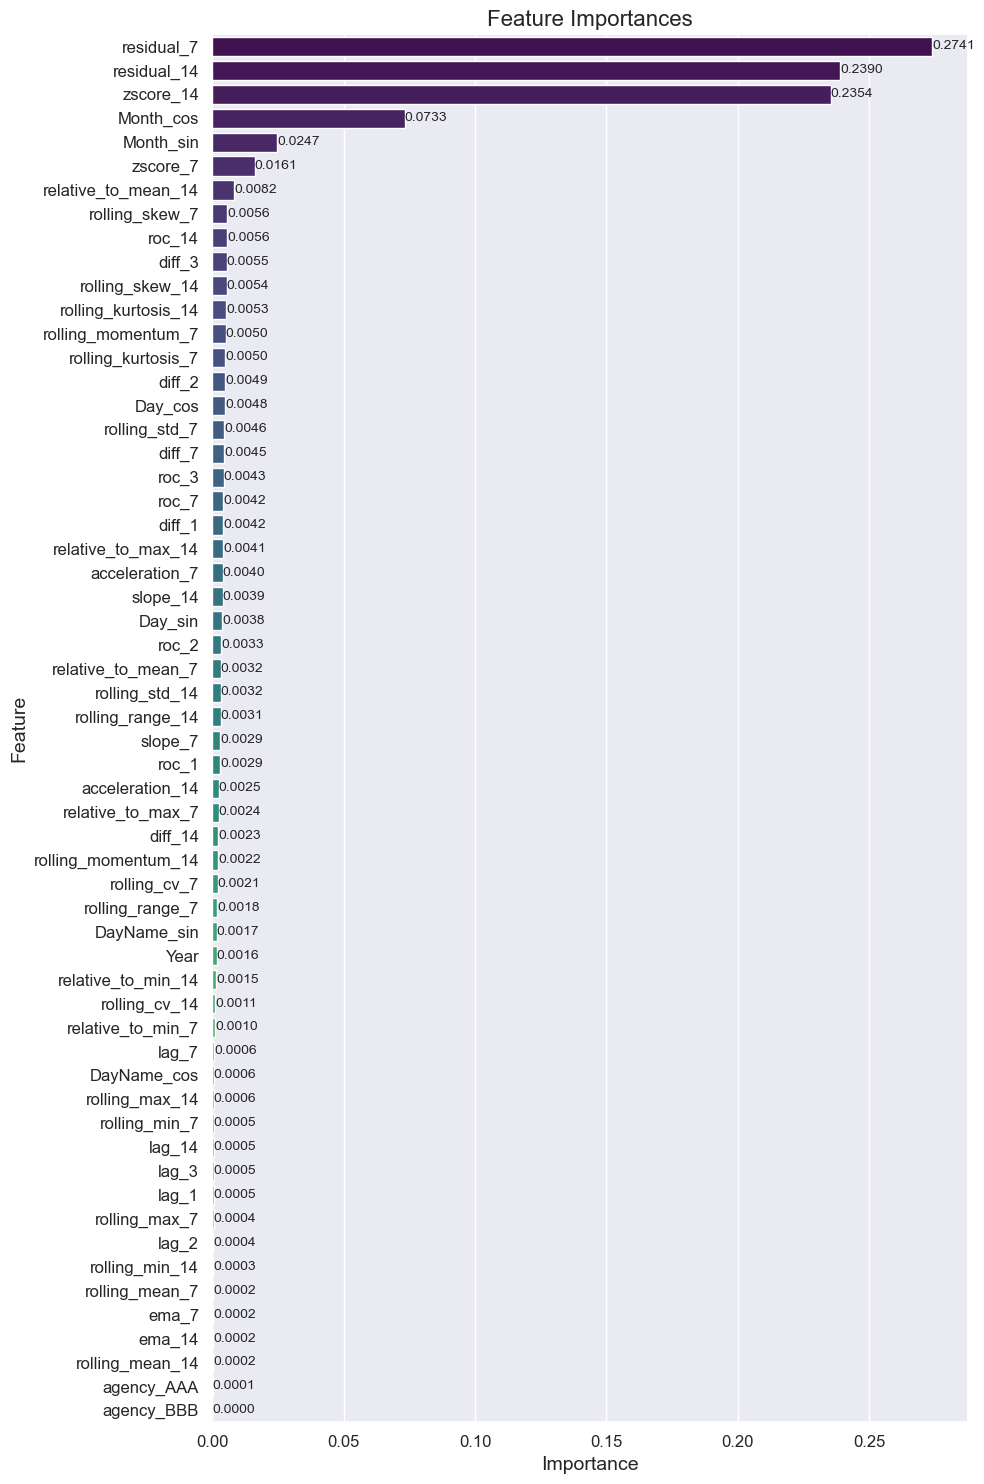

In [49]:
feature_importances = pd.DataFrame({'feature': X_test.columns, 'importance': best_model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=feature_importances, x='importance', y='feature', palette='viridis')
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [50]:
top_features_after_optimization = list(feature_importances[:30]["feature"].values)
top_features_after_optimization

['residual_7',
 'residual_14',
 'zscore_14',
 'Month_cos',
 'Month_sin',
 'zscore_7',
 'relative_to_mean_14',
 'rolling_skew_7',
 'roc_14',
 'diff_3',
 'rolling_skew_14',
 'rolling_kurtosis_14',
 'rolling_momentum_7',
 'rolling_kurtosis_7',
 'diff_2',
 'Day_cos',
 'rolling_std_7',
 'diff_7',
 'roc_3',
 'roc_7',
 'diff_1',
 'relative_to_max_14',
 'acceleration_7',
 'slope_14',
 'Day_sin',
 'roc_2',
 'relative_to_mean_7',
 'rolling_std_14',
 'rolling_range_14',
 'slope_7']

In [51]:
top_features_after_optimization.append("agency_AAA")
top_features_after_optimization.append("agency_BBB")
top_features_after_optimization.append("agency_CCC")

# Retraining the Model with Top Features Only

In [53]:
top_features_after_optimization

['residual_7',
 'residual_14',
 'zscore_14',
 'Month_cos',
 'Month_sin',
 'zscore_7',
 'relative_to_mean_14',
 'rolling_skew_7',
 'roc_14',
 'diff_3',
 'rolling_skew_14',
 'rolling_kurtosis_14',
 'rolling_momentum_7',
 'rolling_kurtosis_7',
 'diff_2',
 'Day_cos',
 'rolling_std_7',
 'diff_7',
 'roc_3',
 'roc_7',
 'diff_1',
 'relative_to_max_14',
 'acceleration_7',
 'slope_14',
 'Day_sin',
 'roc_2',
 'relative_to_mean_7',
 'rolling_std_14',
 'rolling_range_14',
 'slope_7',
 'agency_AAA',
 'agency_BBB',
 'agency_CCC']

In [54]:
X_train = train[top_features_after_optimization]
y_train = train[target]

X_valid = valid[top_features_after_optimization]
y_valid = valid[target]

X_test = test[top_features_after_optimization]
y_test = test[target]

KeyError: "['agency_CCC'] not in index"

In [ ]:
%%time

param_space = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True],
    "n_jobs": [-1],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    "random_state": [42]
}

best_model = optimize_model(X_train, X_valid, y_train, y_valid, param_space, 5)

In [ ]:
best_model

In [ ]:
print("FOR TRAINING SET")
print(classification_report(y_train, best_model.predict(X_train)))

In [ ]:
print("FOR VALIDATIOn SET")
print(classification_report(y_valid, best_model.predict(X_valid)))

In [ ]:
print("FOR TESTING SET")
print(classification_report(y_test, best_model.predict(X_test)))

In [ ]:
feature_importances = pd.DataFrame({'feature': X_test.columns, 'importance': best_model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=feature_importances, x='importance', y='feature', palette='viridis')
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
#for feature in feature_importances['feature'][:5]:
    #print(df_transformed[feature])
 #   sns.scatterplot(ax=axes[i], data=pd.concat[df_transformed[feature], x='date', y='value', hue='anomaly')

# Lets look at performance for each agency

In [ ]:
test_preds = best_model.predict(X_test)

In [ ]:
X_test["target"] = y_test
X_test["prediction"] = test_preds

In [ ]:
X_test = X_test[['agency_AAA', 'agency_BBB', 'agency_CCC', 'target', 'prediction']]

In [ ]:
temp = X_test.copy()
print(classification_report(temp["target"], temp["prediction"]))

In [ ]:
temp = X_test.copy()
print("FOR AGENCY AAA")
temp = temp[temp["agency_AAA"] == 1]
print(classification_report(temp["target"], temp["prediction"]))

In [ ]:
temp = X_test.copy()
print("FOR AGENCY BBB")
temp = temp[temp["agency_BBB"] == 1]
print(classification_report(temp["target"], temp["prediction"]))

In [ ]:
temp = X_test.copy()
print("FOR AGENCY CCC")
temp = temp[temp["agency_CCC"] == 1]
print(classification_report(temp["target"], temp["prediction"]))